In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan

In [ ]:
df = pd.read_csv("/kaggle/input/dataset-drhead/doctorhead_products--875598695.csv", sep = ';')

In [ ]:
def filter_na(df):
    df = df.copy()

    df = df[~df["Цена"].isna()]

    df = df[~df["Бренд"].isna()]
    process_brand = lambda x: "other" if x not in ["apple", "jbl", "audio", "anker", "fiio"] else x
    df["Бренд"] = df["Бренд"].map(process_brand)
    df = df[~df["Тип наушников"].isna()] # беспроводные, проводные

    df = df[~df["Минимальная воспроизводимая частота, Гц"].isna()]
    df = df[~df["Максимальная воспроизводимая частота, кГц"].isna()]

    df["Цвет"] = df["Цвет"].fillna("не указано")
    other_color = lambda x: "other" if x not in ["черный", "белый", "не указано"] else x
    df["Цвет"] = df["Цвет"].map(other_color)

    df = df[~df["Вид наушников"].isna()] # накладные, полноразъёмные
    df = df[~df["Тип акустического оформления"].isna()]


    df["Чехол/футляр в комплекте"] = df["Чехол/футляр в комплекте"].fillna("нет")

    df["Вес, г"] = df["Вес, г"].fillna("0") # признак is_exist * num (ограничения собранных данных)
    in_num = lambda x: float(x.split(",")[0]) if not isinstance(x, int) else float(x)
    df["Вес, г"] = df["Вес, г"].map(in_num)

    df = df[~df["Гарантия, мес"].isna()]
    df = df[~df["Срок службы, мес"].isna()]

    df["Страна производства"] = df["Страна производства"].fillna("не указано")
    country_coding = lambda x: "other" if x not in ["США", "Китай", "не указано"] else x
    df["Страна производства"] = df["Страна производства"].apply(country_coding)

    df[["Встроенный микрофон", "Быстрая зарядка",
        "Беспроводная зарядка", "Складная конструкция"]] = df[["Встроенный микрофон", "Быстрая зарядка",
        "Беспроводная зарядка", "Складная конструкция"]].fillna("нет")

    final_columns = ["Цена", "Бренд", "Тип наушников", "Минимальная воспроизводимая частота, Гц",
                    "Максимальная воспроизводимая частота, кГц", "Цвет", "Вид наушников",
                    "Тип акустического оформления", "Чехол/футляр в комплекте",
                    "Вес, г", "Гарантия, мес", "Срок службы, мес", "Страна производства",
                    "Встроенный микрофон", "Быстрая зарядка", "Беспроводная зарядка", "Складная конструкция"]

    return df[final_columns]

In [ ]:
df = filter_na(df)

In [ ]:
df.to_csv("processed_df.csv")

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_features = [
    "Бренд", "Тип наушников", "Цвет", "Вид наушников",
    "Тип акустического оформления", "Чехол/футляр в комплекте",
    "Страна производства", "Встроенный микрофон",
    "Быстрая зарядка", "Беспроводная зарядка", "Складная конструкция"
]

num_features = [
    "Цена", "Минимальная воспроизводимая частота, Гц",
    "Максимальная воспроизводимая частота, кГц",
    "Вес, г", "Гарантия, мес", "Срок службы, мес"
]
encoder = OneHotEncoder(sparse_output=False, drop = "first").fit(df[cat_features])

df_cat = pd.DataFrame(
    encoder.transform(df[cat_features]),
    columns=encoder.get_feature_names_out(cat_features),
    index=df.index
)

df_final = pd.concat([df[num_features], df_cat], axis = 1)

In [ ]:
df_final.to_csv("dataset_for_regression.csv")

In [ ]:
df_final.shape

(868, 23)

# 0. Влиятельные наблюдения с помощью DFFITS

Критическое значение DFFITS: 0.3256
Количество потенциальных выбросов: 5
Индексы наблюдений с большим влиянием: [ 48  55 290 321 586]


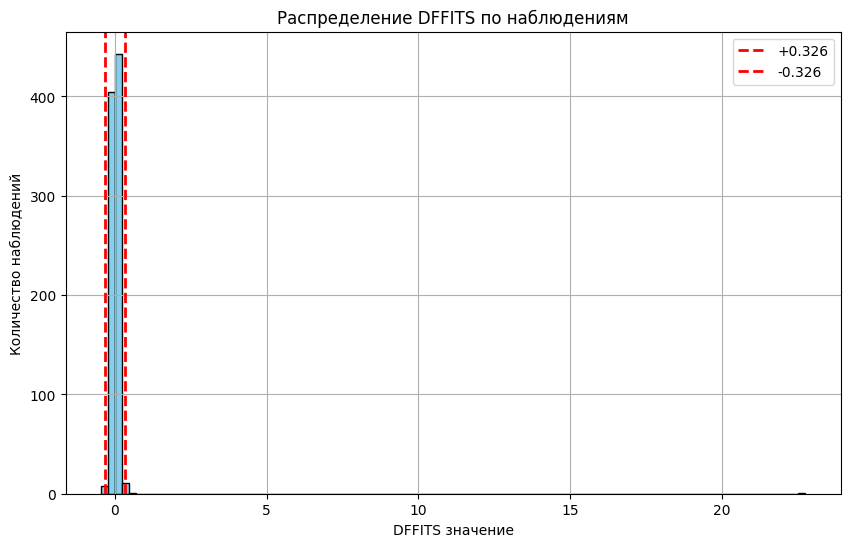

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

X = df_final.drop("Цена", axis = 1).copy()
y = df_final["Цена"]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

influence = OLSInfluence(model)

dffits_values, _ = influence.dffits

n, p = X.shape  # n — количество наблюдений, p — количество признаков +1 (константа)
dffits_threshold = 2 * np.sqrt(p / n)

influential_points = np.where(np.abs(dffits_values) > dffits_threshold)[0]

print(f"Критическое значение DFFITS: {dffits_threshold:.4f}")
print(f"Количество потенциальных выбросов: {len(influential_points)}")
print("Индексы наблюдений с большим влиянием:", influential_points)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(dffits_values, bins=100, color='skyblue', edgecolor='black')

plt.axvline(dffits_threshold, color='red', linestyle='dashed', linewidth=2, label=f"+{dffits_threshold:.3f}")
plt.axvline(-dffits_threshold, color='red', linestyle='dashed', linewidth=2, label=f"-{dffits_threshold:.3f}")

plt.title('Распределение DFFITS по наблюдениям')
plt.xlabel('DFFITS значение')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.grid(True)
plt.savefig("dffits.png", dpi = 300)
plt.show()

In [ ]:
df_cleaned = df_final.drop(index=influential_points).reset_index(drop=True)

# 1. Тесты

## 1.1. Тест Уайта на гетероскедастичность

In [ ]:
from statsmodels.stats.diagnostic import het_white

white_test = het_white(model.resid, model.model.exog)

lm_stat, lm_pvalue, f_stat, f_pvalue = white_test

print(f"LM statistic: {lm_stat:.4f}, p-value: {lm_pvalue:.4f}")
print(f"F-statistic: {f_stat:.4f}, p-value: {f_pvalue:.4f}")


LM statistic: 810.9141, p-value: 0.0000
F-statistic: 46.1667, p-value: 0.0000


## 1.2. Тест Глейзера на гетероскедастичность (с модулем)

In [ ]:
residuals = model.resid
abs_residuals = np.abs(residuals)
X_for_glejser = model.model.exog


model_glejser = sm.OLS(abs_residuals, X_for_glejser).fit()

print(model_glejser.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     6.663
Date:                Fri, 02 May 2025   Prob (F-statistic):           1.45e-18
Time:                        07:48:01   Log-Likelihood:                -11821.
No. Observations:                 868   AIC:                         2.369e+04
Df Residuals:                     845   BIC:                         2.380e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9335.6681   1.25e+05     -0.075      0.9

## 2.1 Матрица корреляций признаков

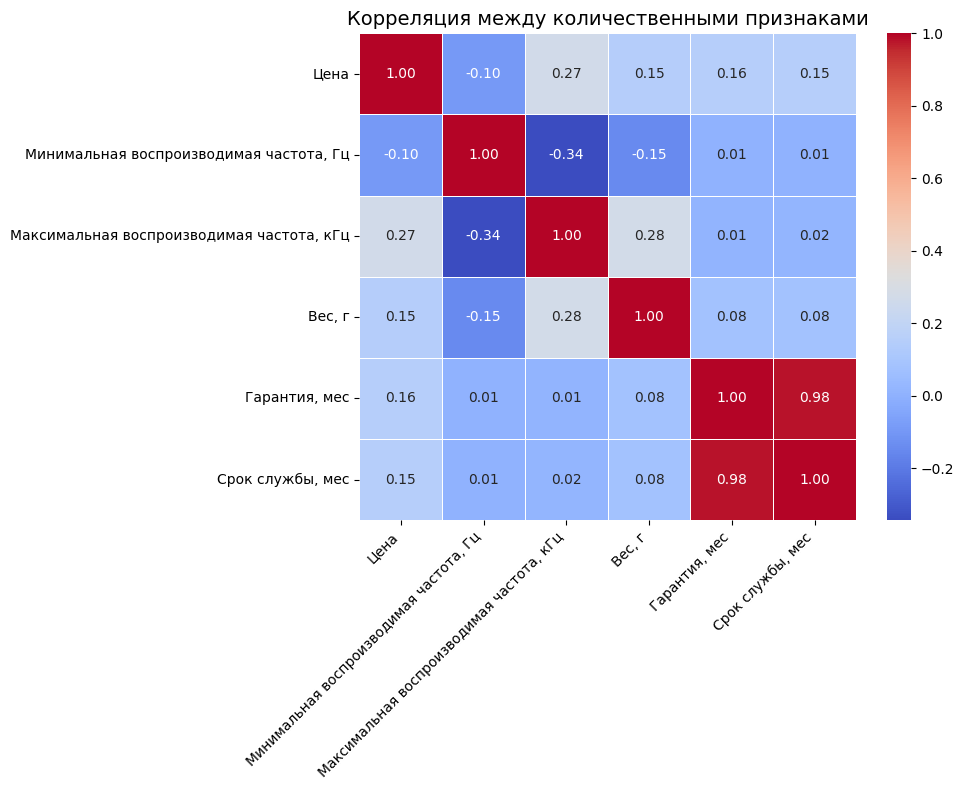

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

correlation_matrix = df[num_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 10})


plt.title('Корреляция между количественными признаками', fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()


plt.savefig("correlation_plot.png", dpi = 300)
plt.show()


## 2.2. VIF

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


X = df_cleaned[num_features]
X_const = add_constant(X)


vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif_data)


                                     feature         VIF
0                                      const  271.557461
1                                       Цена    1.111891
2    Минимальная воспроизводимая частота, Гц    1.137223
3  Максимальная воспроизводимая частота, кГц    1.275085
4                                     Вес, г    1.098735
5                              Гарантия, мес   24.440959
6                           Срок службы, мес   24.412872


In [ ]:
df_cleaned = df_cleaned.drop("Гарантия, мес", axis = 1)

## 2. Функциональная форма

Оптимальное значение λ для Box-Cox преобразования: -0.046586884275252885


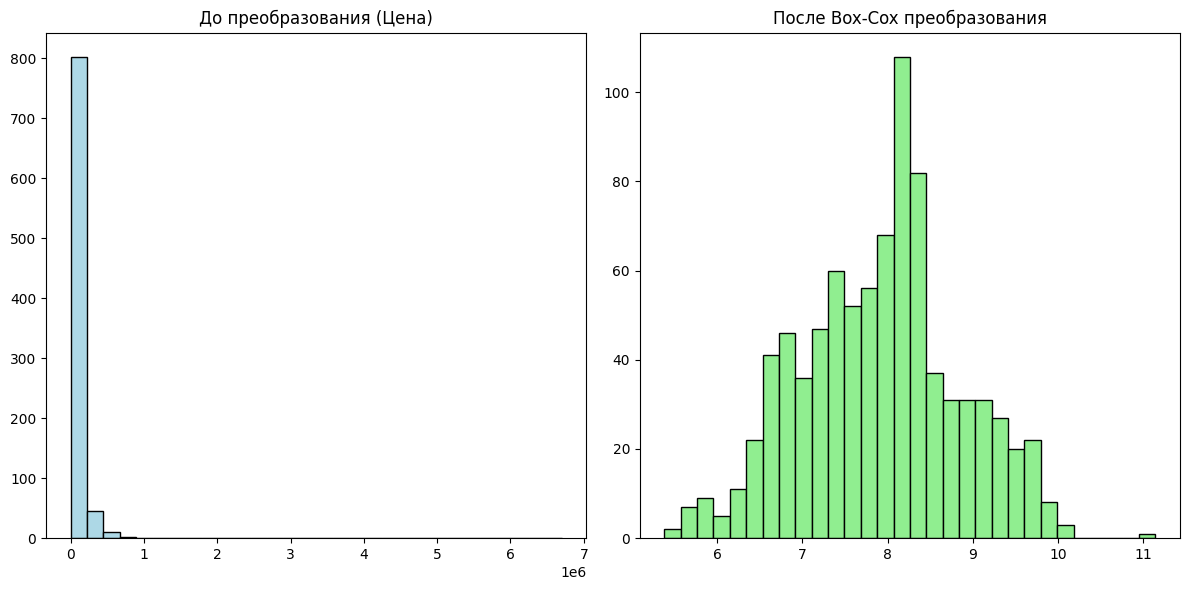

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


y = df_cleaned["Цена"]

# Бокс-кокс

y_boxcox, best_lambda = stats.boxcox(y)

print(f"Оптимальное значение λ для Box-Cox преобразования: {best_lambda}")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].hist(y, bins=30, color='lightblue', edgecolor='black')
axes[0].set_title("До преобразования (Цена)")

axes[1].hist(y_boxcox, bins=30, color='lightgreen', edgecolor='black')
axes[1].set_title("После Box-Cox преобразования")

plt.tight_layout()
plt.savefig("Optimal box_cox.png", dpi = 300)
plt.show()


In [ ]:
df_cleaned["Цена"] = y_boxcox

## 2.2. Нормальность остатков

Тест Шапиро-Уилка на нормальность остатков:
Статистика: 0.989309323452954, p-value: 6.289411490495294e-06


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


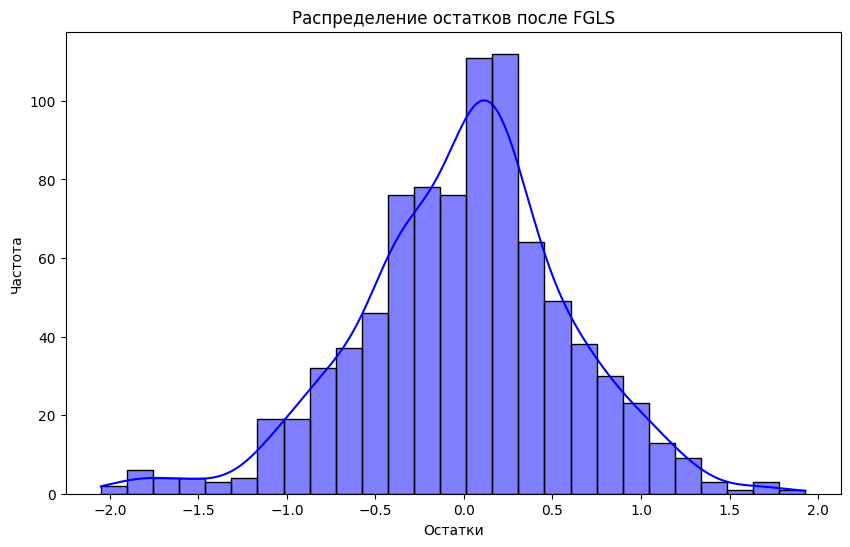

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan


X = df_cleaned.drop("Цена", axis = 1)
X = sm.add_constant(X)
y = df_cleaned["Цена"]

model_fgls = sm.GLS(y, X).fit()

fgls_residuals = y - model_fgls.fittedvalues

shapiro_test = stats.shapiro(fgls_residuals)
print("Тест Шапиро-Уилка на нормальность остатков:")
print(f"Статистика: {shapiro_test[0]}, p-value: {shapiro_test[1]}")

plt.figure(figsize=(10, 6))
sns.histplot(fgls_residuals, kde=True, color='blue')
plt.title('Распределение остатков после FGLS')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.savefig("residuals_for_partly_model.png", dpi = 300)
plt.show()

Тест Шапиро-Уилка на нормальность остатков:
Статистика: 0.9862983836191769, p-value: 3.2108233662786896e-07


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


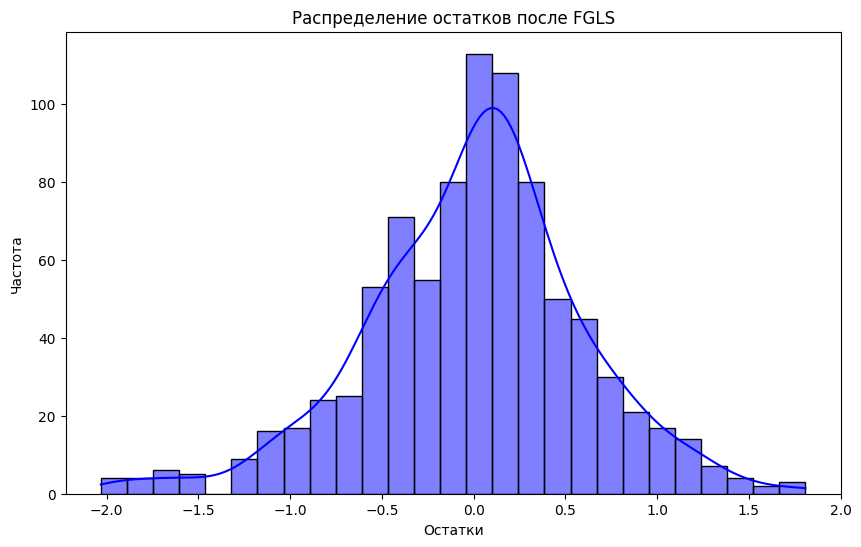

In [ ]:
# логарифмическая форма
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan


X = df_cleaned.drop("Цена", axis = 1)
X = sm.add_constant(X)
X[["Минимальная воспроизводимая частота, Гц", "Максимальная воспроизводимая частота, кГц", "Вес, г"]] = np.log1p(X[["Минимальная воспроизводимая частота, Гц", "Максимальная воспроизводимая частота, кГц", "Вес, г"]])
y = df_cleaned["Цена"]

model_fgls = sm.GLS(y, X).fit()

fgls_residuals = y - model_fgls.fittedvalues

shapiro_test = stats.shapiro(fgls_residuals)
print("Тест Шапиро-Уилка на нормальность остатков:")
print(f"Статистика: {shapiro_test[0]}, p-value: {shapiro_test[1]}")

plt.figure(figsize=(10, 6))
sns.histplot(fgls_residuals, kde=True, color='blue')
plt.title('Распределение остатков после FGLS')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.savefig("residuals_for_log_model.png", dpi = 300)
plt.show()

In [ ]:
# финальная оценка модели

X = df_cleaned.drop("Цена", axis = 1)
X = sm.add_constant(X)
y = df_cleaned["Цена"]

model_fgls = sm.GLS(y, X).fit()

fgls_residuals = y - model_fgls.fittedvalues

In [ ]:
print(model_fgls.summary())

                            GLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.592
Model:                            GLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     58.13
Date:                Sat, 03 May 2025   Prob (F-statistic):          1.03e-147
Time:                        06:17:52   Log-Likelihood:                -768.37
No. Observations:                 863   AIC:                             1581.
Df Residuals:                     841   BIC:                             1685.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [ ]:
import statsmodels.api as sm
from scipy.stats import chi2


X_null = np.ones_like(y)
model_null = sm.GLM(y, X_null, family=sm.families.Gaussian(), link=sm.families.links.identity()).fit()


lr_stat = 2 * (model_fgls.llf - model_null.llf)
df_diff = X.shape[1] - 1
p_value = chi2.sf(lr_stat, df_diff)

print(f"Логарифмическое правдоподобие для полной модели: {model_fgls.llf}")
print(f"Логарифмическое правдоподобие для ограниченной модели: {model_null.llf}")
print(f"Логарифмическая правдоподобие статистика: {lr_stat}")
print(f"p-value для теста правдоподобия: {p_value}")
# модель значима

Логарифмическое правдоподобие для полной модели: -768.36757222099
Логарифмическое правдоподобие для ограниченной модели: -1155.2866671667414
Логарифмическая правдоподобие статистика: 773.8381898915027
p-value для теста правдоподобия: 3.176834225740969e-150


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['link']
  warnings.warn(msg, ValueWarning)


## 2.3 Предельные эффекты

In [ ]:
X.columns

Index(['const', 'Минимальная воспроизводимая частота, Гц',
       'Максимальная воспроизводимая частота, кГц', 'Вес, г',
       'Срок службы, мес', 'Тип наушников_проводные',
       'Тип наушников_проводные, беспроводные', 'Цвет_белый',
       'Цвет_не указано', 'Цвет_черный', 'Вид наушников_накладные',
       'Вид наушников_полноразмерные', 'Тип акустического оформления_открытые',
       'Тип акустического оформления_полуоткрытые',
       'Чехол/футляр в комплекте_нет', 'Страна производства_Китай',
       'Страна производства_США', 'Страна производства_не указано',
       'Встроенный микрофон_нет', 'Быстрая зарядка_нет',
       'Беспроводная зарядка_нет', 'Складная конструкция_нет'],
      dtype='object')

In [ ]:
num_features = ['Минимальная воспроизводимая частота, Гц',
       'Максимальная воспроизводимая частота, кГц', 'Вес, г',
       'Срок службы, мес']
cat_features = [col for col in X.columns if col not in num_features and col != "const"]

predictions = model_fgls.fittedvalues

h = (1+best_lambda*predictions)**(1/best_lambda - 1)
for feature in num_features:
    beta = model_fgls.params[feature]
    AME = (h*beta).mean()
    print(f"AME for {feature} = {AME}")

AME for Минимальная воспроизводимая частота, Гц = -257.37961499128465
AME for Максимальная воспроизводимая частота, кГц = 824.6068358526707
AME for Вес, г = 86.93734640402882
AME for Срок службы, мес = 850.5589599392104


In [ ]:
for feature in cat_features:
    X1 = X.copy()
    X2 = X.copy()

    X1[feature] = 1
    X2[feature] = 0

    # y_i | x_k = 1 - y_i | x_k = 0
    preds1 = (1+best_lambda*model_fgls.predict(X1))**(1/best_lambda)
    preds2 = (1+best_lambda*model_fgls.predict(X2)) ** (1/best_lambda)
    AME = (preds1 - preds2).mean()
    print(f"AME for {feature} = {AME}")


AME for Тип наушников_проводные = -33384.6474585984
AME for Тип наушников_проводные, беспроводные = 105342.4600821978
AME for Цвет_белый = -19974.310007242744
AME for Цвет_не указано = 19343.015474603944
AME for Цвет_черный = -8461.688805230531
AME for Вид наушников_накладные = -5722.104804333468
AME for Вид наушников_полноразмерные = 229.00666889380716
AME for Тип акустического оформления_открытые = 15825.893551279325
AME for Тип акустического оформления_полуоткрытые = -12666.757059834501
AME for Чехол/футляр в комплекте_нет = -26815.016434704416
AME for Страна производства_Китай = -24599.17949597072
AME for Страна производства_США = 66959.2101170478
AME for Страна производства_не указано = -15130.324163065807
AME for Встроенный микрофон_нет = 64169.5037391271
AME for Быстрая зарядка_нет = -22612.84177310588
AME for Беспроводная зарядка_нет = -52518.50911432237
AME for Складная конструкция_нет = 5863.8347903947915


## 4. Квантильная регрессия

In [ ]:
import statsmodels.api as sm
import pandas as pd

X = df_cleaned.drop("Цена", axis=1)
X = sm.add_constant(X)
y = df_cleaned["Цена"]


quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
results_dict = {}


for q in quantiles:
    model = sm.QuantReg(y, X, )
    result = model.fit(q=q)
    results_dict[q] = result.summary2().tables[1]


for q in quantiles:
    print(f"Результаты для квантиля q={q}:")
    print(results_dict[q])
    print("\n" + "="*50 + "\n")


/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2215: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2215: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2215: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Результаты для квантиля q=0.1:
                                              Coef.  Std.Err.          t  \
const                                      7.132296  0.258827  27.556207   
Минимальная воспроизводимая частота, Гц   -0.010694  0.001619  -6.605633   
Максимальная воспроизводимая частота, кГц  0.013063  0.002843   4.594761   
Вес, г                                     0.001068  0.000525   2.033537   
Срок службы, мес                           0.020964  0.005839   3.590637   
Тип наушников_проводные                   -0.288289  0.174510  -1.651994   
Тип наушников_проводные, беспроводные      1.200166  1.235747   0.971207   
Цвет_белый                                -0.175180  0.114182  -1.534218   
Цвет_не указано                            0.332669  0.083031   4.006556   
Цвет_черный                               -0.175180  0.076260  -2.297151   
Вид наушников_накладные                    0.108242  0.179742   0.602207   
Вид наушников_полноразмерные               0.103741  0.18

/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2215: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2215: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


## 4.1. Графики квантильной регрессии

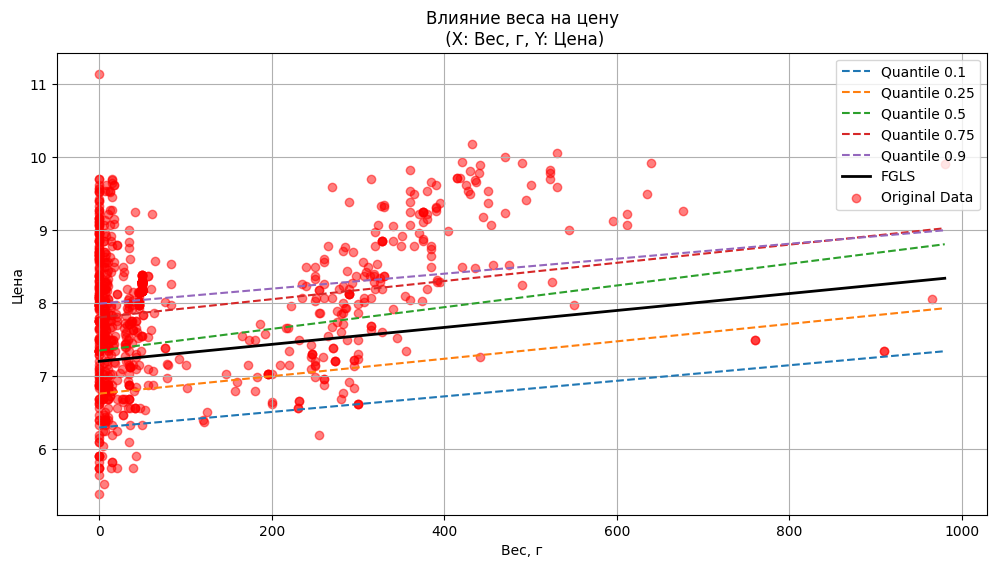

In [ ]:
weight_range = np.linspace(X["Вес, г"].min(), X["Вес, г"].max(), 100)

X_fixed = pd.DataFrame({col: [X[col].median()] * len(weight_range) for col in X.columns})
X_fixed["Вес, г"] = weight_range


quantile_predictions = {}
for q in quantiles:
    model = sm.QuantReg(y, X)
    result = model.fit(q=q, cov_type='HC3')
    quantile_predictions[q] = result.predict(X_fixed)


fgls_predictions = model_fgls.predict(X_fixed)


plt.figure(figsize=(12, 6))

for q in quantiles:
    plt.plot(weight_range, quantile_predictions[q], label=f'Quantile {q}', linestyle='--')

plt.plot(weight_range, fgls_predictions, label='FGLS', color='black', linewidth=2)
plt.scatter(df_cleaned["Вес, г"], y, label='Original Data', color='red', alpha=0.5)

plt.title("Влияние веса на цену\n (X: Вес, г, Y: Цена)")
plt.xlabel("Вес, г")
plt.ylabel("Цена")
plt.legend()
plt.grid(True)
plt.savefig("quantile_regression.png", dpi = 300)
plt.show()


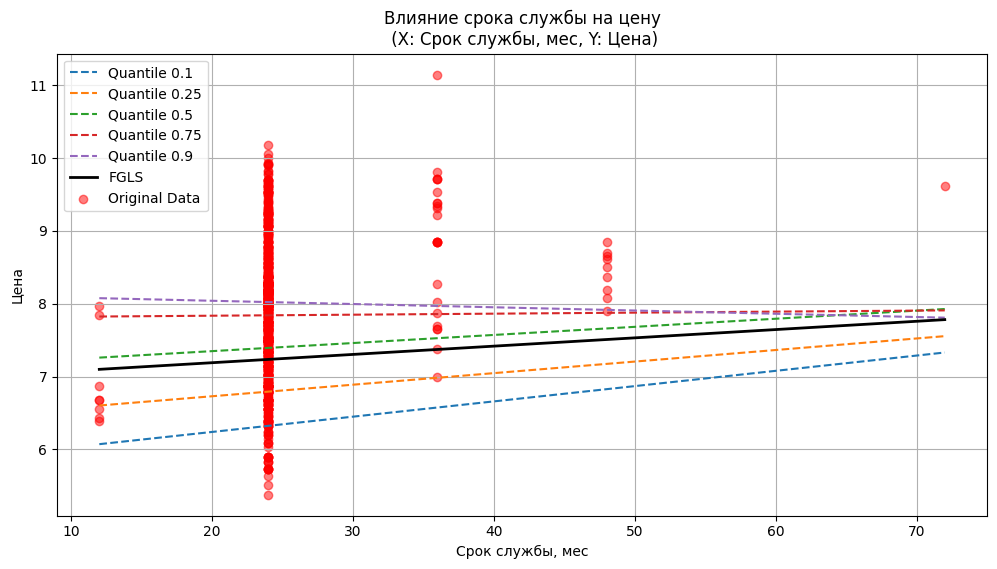

In [ ]:
lifespan_range = np.linspace(X["Срок службы, мес"].min(), X["Срок службы, мес"].max(), 100)

X_fixed = pd.DataFrame({col: [X[col].median()] * len(lifespan_range) for col in X.columns})
X_fixed["Срок службы, мес"] = lifespan_range


quantile_predictions = {}
for q in quantiles:
    model = sm.QuantReg(y, X)
    result = model.fit(q=q, cov_type='HC3')
    quantile_predictions[q] = result.predict(X_fixed)


fgls_predictions = model_fgls.predict(X_fixed)


plt.figure(figsize=(12, 6))

for q in quantiles:
    plt.plot(lifespan_range, quantile_predictions[q], label=f'Quantile {q}', linestyle='--')

plt.plot(lifespan_range, fgls_predictions, label='FGLS', color='black', linewidth=2)
plt.scatter(df_cleaned["Срок службы, мес"], y, label='Original Data', color='red', alpha=0.5)

plt.title("Влияние срока службы на цену\n (X: Срок службы, мес, Y: Цена)")
plt.xlabel("Срок службы, мес")
plt.ylabel("Цена")
plt.legend()
plt.grid(True)
plt.savefig("quantile_regression2.png", dpi = 300)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from tqdm import tqdm
from scipy import stats
from warnings import filterwarnings
filterwarnings("ignore")


np.random.seed(1001)


quantiles_mq = [0.1, 0.25, 0.5, 0.75, 0.9]
models_mq = []  # здесь будем хранить финальные модели с правильными стандартными ошибками
n_boot = 50
predictors = df_cleaned.drop("Цена", axis=1).columns

X = sm.add_constant(df_cleaned[predictors])
y = df_cleaned['Цена']


#print("Запуск бутстрэээпа")
bootstrap_coefs = {q: [] for q in quantiles_mq}
for _ in tqdm(range(n_boot), desc="Прогресс"):
    bootstrap_sample = df_cleaned.sample(n=500, replace=True)
    X_boot = sm.add_constant(bootstrap_sample[predictors])
    y_boot = bootstrap_sample['Цена']

    for q in quantiles_mq:
        model = sm.QuantReg(y_boot, X_boot).fit(q=q, cov_type='HC3')
        bootstrap_coefs[q].append(model.params)

for q in quantiles_mq:
    main_model = sm.QuantReg(y, X).fit(q=q)
    coefs = pd.DataFrame(bootstrap_coefs[q], columns=predictors)
    bse = coefs.std()


    main_model.bse = bse.values  # перезаписываем стандартные ошибки
    models_mq.append(main_model)


def create_results_table(q):
    main_model = sm.QuantReg(y, X).fit(q=q)
    coefs_df = pd.DataFrame(bootstrap_coefs[q], columns=predictors)
    bse = coefs_df.std()

    results = pd.DataFrame({
        'factor': predictors,
        'coeff': [main_model.params[p] for p in predictors],
        'std err (boot)': [bse[p] for p in predictors],
        '95% CI low': [main_model.params[p] - 1.96*bse[p] for p in predictors],
        '95% CI high': [main_model.params[p] + 1.96*bse[p] for p in predictors],
        't-stat': [main_model.params[p]/bse[p] for p in predictors],
        'p-value': [2*(1-stats.norm.cdf(abs(main_model.params[p]/bse[p]))) for p in predictors]
    })

    for col in results.columns[1:]:
        results[col] = results[col].apply(lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x)

    return results

for q in quantiles_mq:
    print(f"\n{'='*80}")
    print(f"=== Результаты квантильной регрессии для квантиля {q} (бутстрэп, n={n_boot}) ===")
    print(f"{'='*80}\n")

    results_table = create_results_table(q)
    display(results_table)

Запуск бутстрэп-процедуры...


Прогресс: 100%|██████████| 50/50 [00:27<00:00,  1.81it/s]



=== Результаты квантильной регрессии для квантиля 0.1 (бутстрэп, n=50) ===



,factor,coeff,std err (boot),95% CI low,95% CI high,t-stat,p-value
0,"Минимальная воспроизводимая частота, Гц",-0.0107,0.0099,-0.0302,0.0088,-1.0756,0.2821
1,"Максимальная воспроизводимая частота, кГц",0.0131,0.0082,-0.0030,0.0292,1.5903,0.1118
2,"Вес, г",0.0011,0.0007,-0.0003,0.0024,1.5464,0.1220
3,"Срок службы, мес",0.0210,0.0179,-0.0142,0.0561,1.1698,0.2421
4,Тип наушников_проводные,-0.2883,0.3293,-0.9338,0.3572,-0.8754,0.3813
5,"Тип наушников_проводные, беспроводные",1.2002,0.6916,-0.1554,2.5557,1.7354,0.0827
6,Цвет_белый,-0.1752,0.1535,-0.4760,0.1257,-1.1413,0.2537
7,Цвет_не указано,0.3327,0.1780,-0.0162,0.6815,1.8690,0.0616
8,Цвет_черный,-0.1752,0.1600,-0.4888,0.1384,-1.0948,0.2736
9,Вид наушников_накладные,0.1082,0.2589,-0.3992,0.6157,0.4180,0.6759



=== Результаты квантильной регрессии для квантиля 0.25 (бутстрэп, n=50) ===



,factor,coeff,std err (boot),95% CI low,95% CI high,t-stat,p-value
0,"Минимальная воспроизводимая частота, Гц",-0.0018,0.0077,-0.0169,0.0132,-0.2384,0.8116
1,"Максимальная воспроизводимая частота, кГц",0.0126,0.0044,0.0040,0.0212,2.8644,0.0042
2,"Вес, г",0.0012,0.0007,-0.0002,0.0026,1.6812,0.0927
3,"Срок службы, мес",0.0159,0.0109,-0.0055,0.0372,1.4573,0.1450
4,Тип наушников_проводные,-0.3611,0.2350,-0.8218,0.0996,-1.5361,0.1245
5,"Тип наушников_проводные, беспроводные",0.9600,0.5567,-0.1311,2.0510,1.7245,0.0846
6,Цвет_белый,-0.3738,0.1250,-0.6189,-0.1288,-2.9903,0.0028
7,Цвет_не указано,0.2834,0.1178,0.0525,0.5143,2.4058,0.0161
8,Цвет_черный,-0.2272,0.0913,-0.4062,-0.0482,-2.4878,0.0129
9,Вид наушников_накладные,0.1228,0.2298,-0.3276,0.5731,0.5343,0.5931



=== Результаты квантильной регрессии для квантиля 0.5 (бутстрэп, n=50) ===



,factor,coeff,std err (boot),95% CI low,95% CI high,t-stat,p-value
0,"Минимальная воспроизводимая частота, Гц",-0.0021,0.0069,-0.0156,0.0113,-0.3106,0.7561
1,"Максимальная воспроизводимая частота, кГц",0.0095,0.0035,0.0026,0.0163,2.7034,0.0069
2,"Вес, г",0.0015,0.0006,0.0003,0.0027,2.3837,0.0171
3,"Срок службы, мес",0.0111,0.0079,-0.0044,0.0266,1.4031,0.1606
4,Тип наушников_проводные,-0.4542,0.2618,-0.9673,0.0589,-1.7350,0.0827
5,"Тип наушников_проводные, беспроводные",0.7126,0.4336,-0.1372,1.5624,1.6436,0.1003
6,Цвет_белый,-0.4464,0.1169,-0.6756,-0.2173,-3.8186,0.0001
7,Цвет_не указано,0.1463,0.0533,0.0419,0.2508,2.7468,0.0060
8,Цвет_черный,-0.1719,0.0914,-0.3511,0.0072,-1.8808,0.0600
9,Вид наушников_накладные,-0.0683,0.1912,-0.4431,0.3065,-0.3573,0.7209



=== Результаты квантильной регрессии для квантиля 0.75 (бутстрэп, n=50) ===



,factor,coeff,std err (boot),95% CI low,95% CI high,t-stat,p-value
0,"Минимальная воспроизводимая частота, Гц",-0.0041,0.0040,-0.0120,0.0038,-1.0197,0.3079
1,"Максимальная воспроизводимая частота, кГц",0.0100,0.0055,-0.0009,0.0209,1.8030,0.0714
2,"Вес, г",0.0012,0.0006,0.0000,0.0025,2.0137,0.0440
3,"Срок службы, мес",0.0014,0.0107,-0.0195,0.0223,0.1316,0.8953
4,Тип наушников_проводные,-0.5980,0.2272,-1.0434,-0.1527,-2.6323,0.0085
5,"Тип наушников_проводные, беспроводные",0.7237,0.4501,-0.1585,1.6059,1.6078,0.1079
6,Цвет_белый,-0.3256,0.1448,-0.6094,-0.0418,-2.2484,0.0246
7,Цвет_не указано,0.1663,0.0754,0.0185,0.3142,2.2052,0.0274
8,Цвет_черный,-0.0995,0.0832,-0.2624,0.0635,-1.1961,0.2316
9,Вид наушников_накладные,-0.0696,0.2257,-0.5119,0.3728,-0.3082,0.7579



=== Результаты квантильной регрессии для квантиля 0.9 (бутстрэп, n=50) ===



,factor,coeff,std err (boot),95% CI low,95% CI high,t-stat,p-value
0,"Минимальная воспроизводимая частота, Гц",-0.0050,0.0035,-0.0119,0.0020,-1.3972,0.1623
1,"Максимальная воспроизводимая частота, кГц",0.0059,0.0056,-0.0050,0.0168,1.0674,0.2858
2,"Вес, г",0.0010,0.0006,-0.0002,0.0022,1.6952,0.0900
3,"Срок службы, мес",-0.0045,0.0189,-0.0416,0.0326,-0.2355,0.8138
4,Тип наушников_проводные,-0.4719,0.2144,-0.8921,-0.0516,-2.2009,0.0277
5,"Тип наушников_проводные, беспроводные",0.6286,0.4803,-0.3127,1.5699,1.3090,0.1905
6,Цвет_белый,-0.2784,0.1843,-0.6397,0.0829,-1.5104,0.1309
7,Цвет_не указано,0.1350,0.1165,-0.0934,0.3634,1.1584,0.2467
8,Цвет_черный,-0.1624,0.0975,-0.3535,0.0288,-1.6647,0.0960
9,Вид наушников_накладные,-0.0710,0.3014,-0.6617,0.5197,-0.2355,0.8138


In [ ]:
predictors.shape

(21,)

In [ ]:
len(X.columns)

22

In [ ]:
models_mq[-1].bse

array([0.00354377, 0.00555986, 0.00060613, 0.0189312 , 0.21440301,
       0.48025422, 0.18433137, 0.11652928, 0.09753618, 0.301381  ,
       0.27353285, 0.19752175, 0.31272878, 0.18838075, 0.12049775,
       0.1460826 , 0.13316936, 0.2256057 , 0.12892498, 0.10841239,
       0.18409822])

In [ ]:
len(all_features)

21

In [ ]:
len(models_mq[0].params.index)

22

In [ ]:
bse_index

{'const': 0,
 'Минимальная воспроизводимая частота, Гц': 1,
 'Максимальная воспроизводимая частота, кГц': 2,
 'Вес, г': 3,
 'Срок службы, мес': 4,
 'Тип наушников_проводные': 5,
 'Тип наушников_проводные, беспроводные': 6,
 'Цвет_белый': 7,
 'Цвет_не указано': 8,
 'Цвет_черный': 9,
 'Вид наушников_накладные': 10,
 'Вид наушников_полноразмерные': 11,
 'Тип акустического оформления_открытые': 12,
 'Тип акустического оформления_полуоткрытые': 13,
 'Чехол/футляр в комплекте_нет': 14,
 'Страна производства_Китай': 15,
 'Страна производства_США': 16,
 'Страна производства_не указано': 17,
 'Встроенный микрофон_нет': 18,
 'Быстрая зарядка_нет': 19,
 'Беспроводная зарядка_нет': 20,
 'Складная конструкция_нет': 21}

In [ ]:
ols_model = sm.GLS(y,X).fit()


In [ ]:
ols_model.conf_int()

,0,1
const,7.388261,8.206160
"Минимальная воспроизводимая частота, Гц",-0.007154,0.000272
"Максимальная воспроизводимая частота, кГц",0.006897,0.015152
"Вес, г",0.000687,0.001638
"Срок службы, мес",-0.000117,0.022860
Тип наушников_проводные,-0.554070,-0.149299
"Тип наушников_проводные, беспроводные",-0.145841,1.535105
Цвет_белый,-0.503155,-0.208390
Цвет_не указано,0.131857,0.363822
Цвет_черный,-0.219050,-0.014818


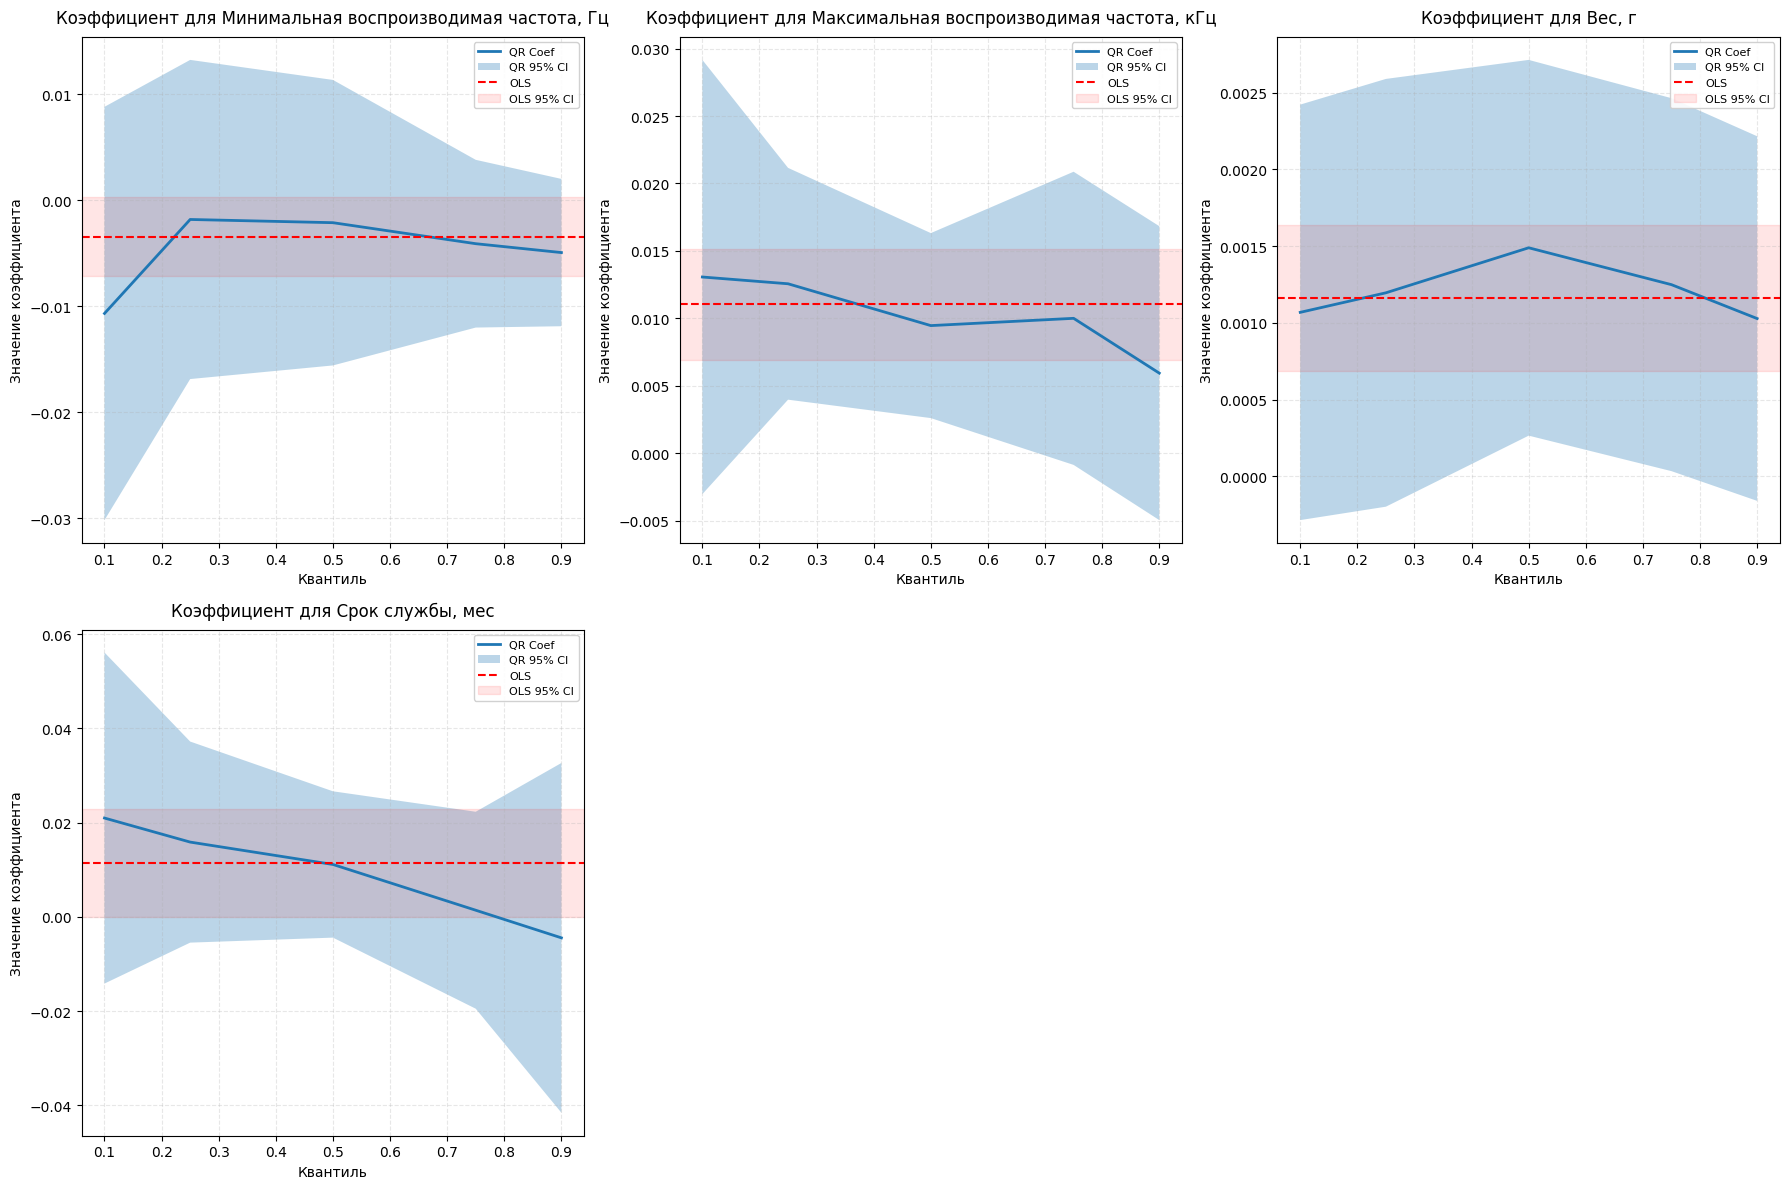

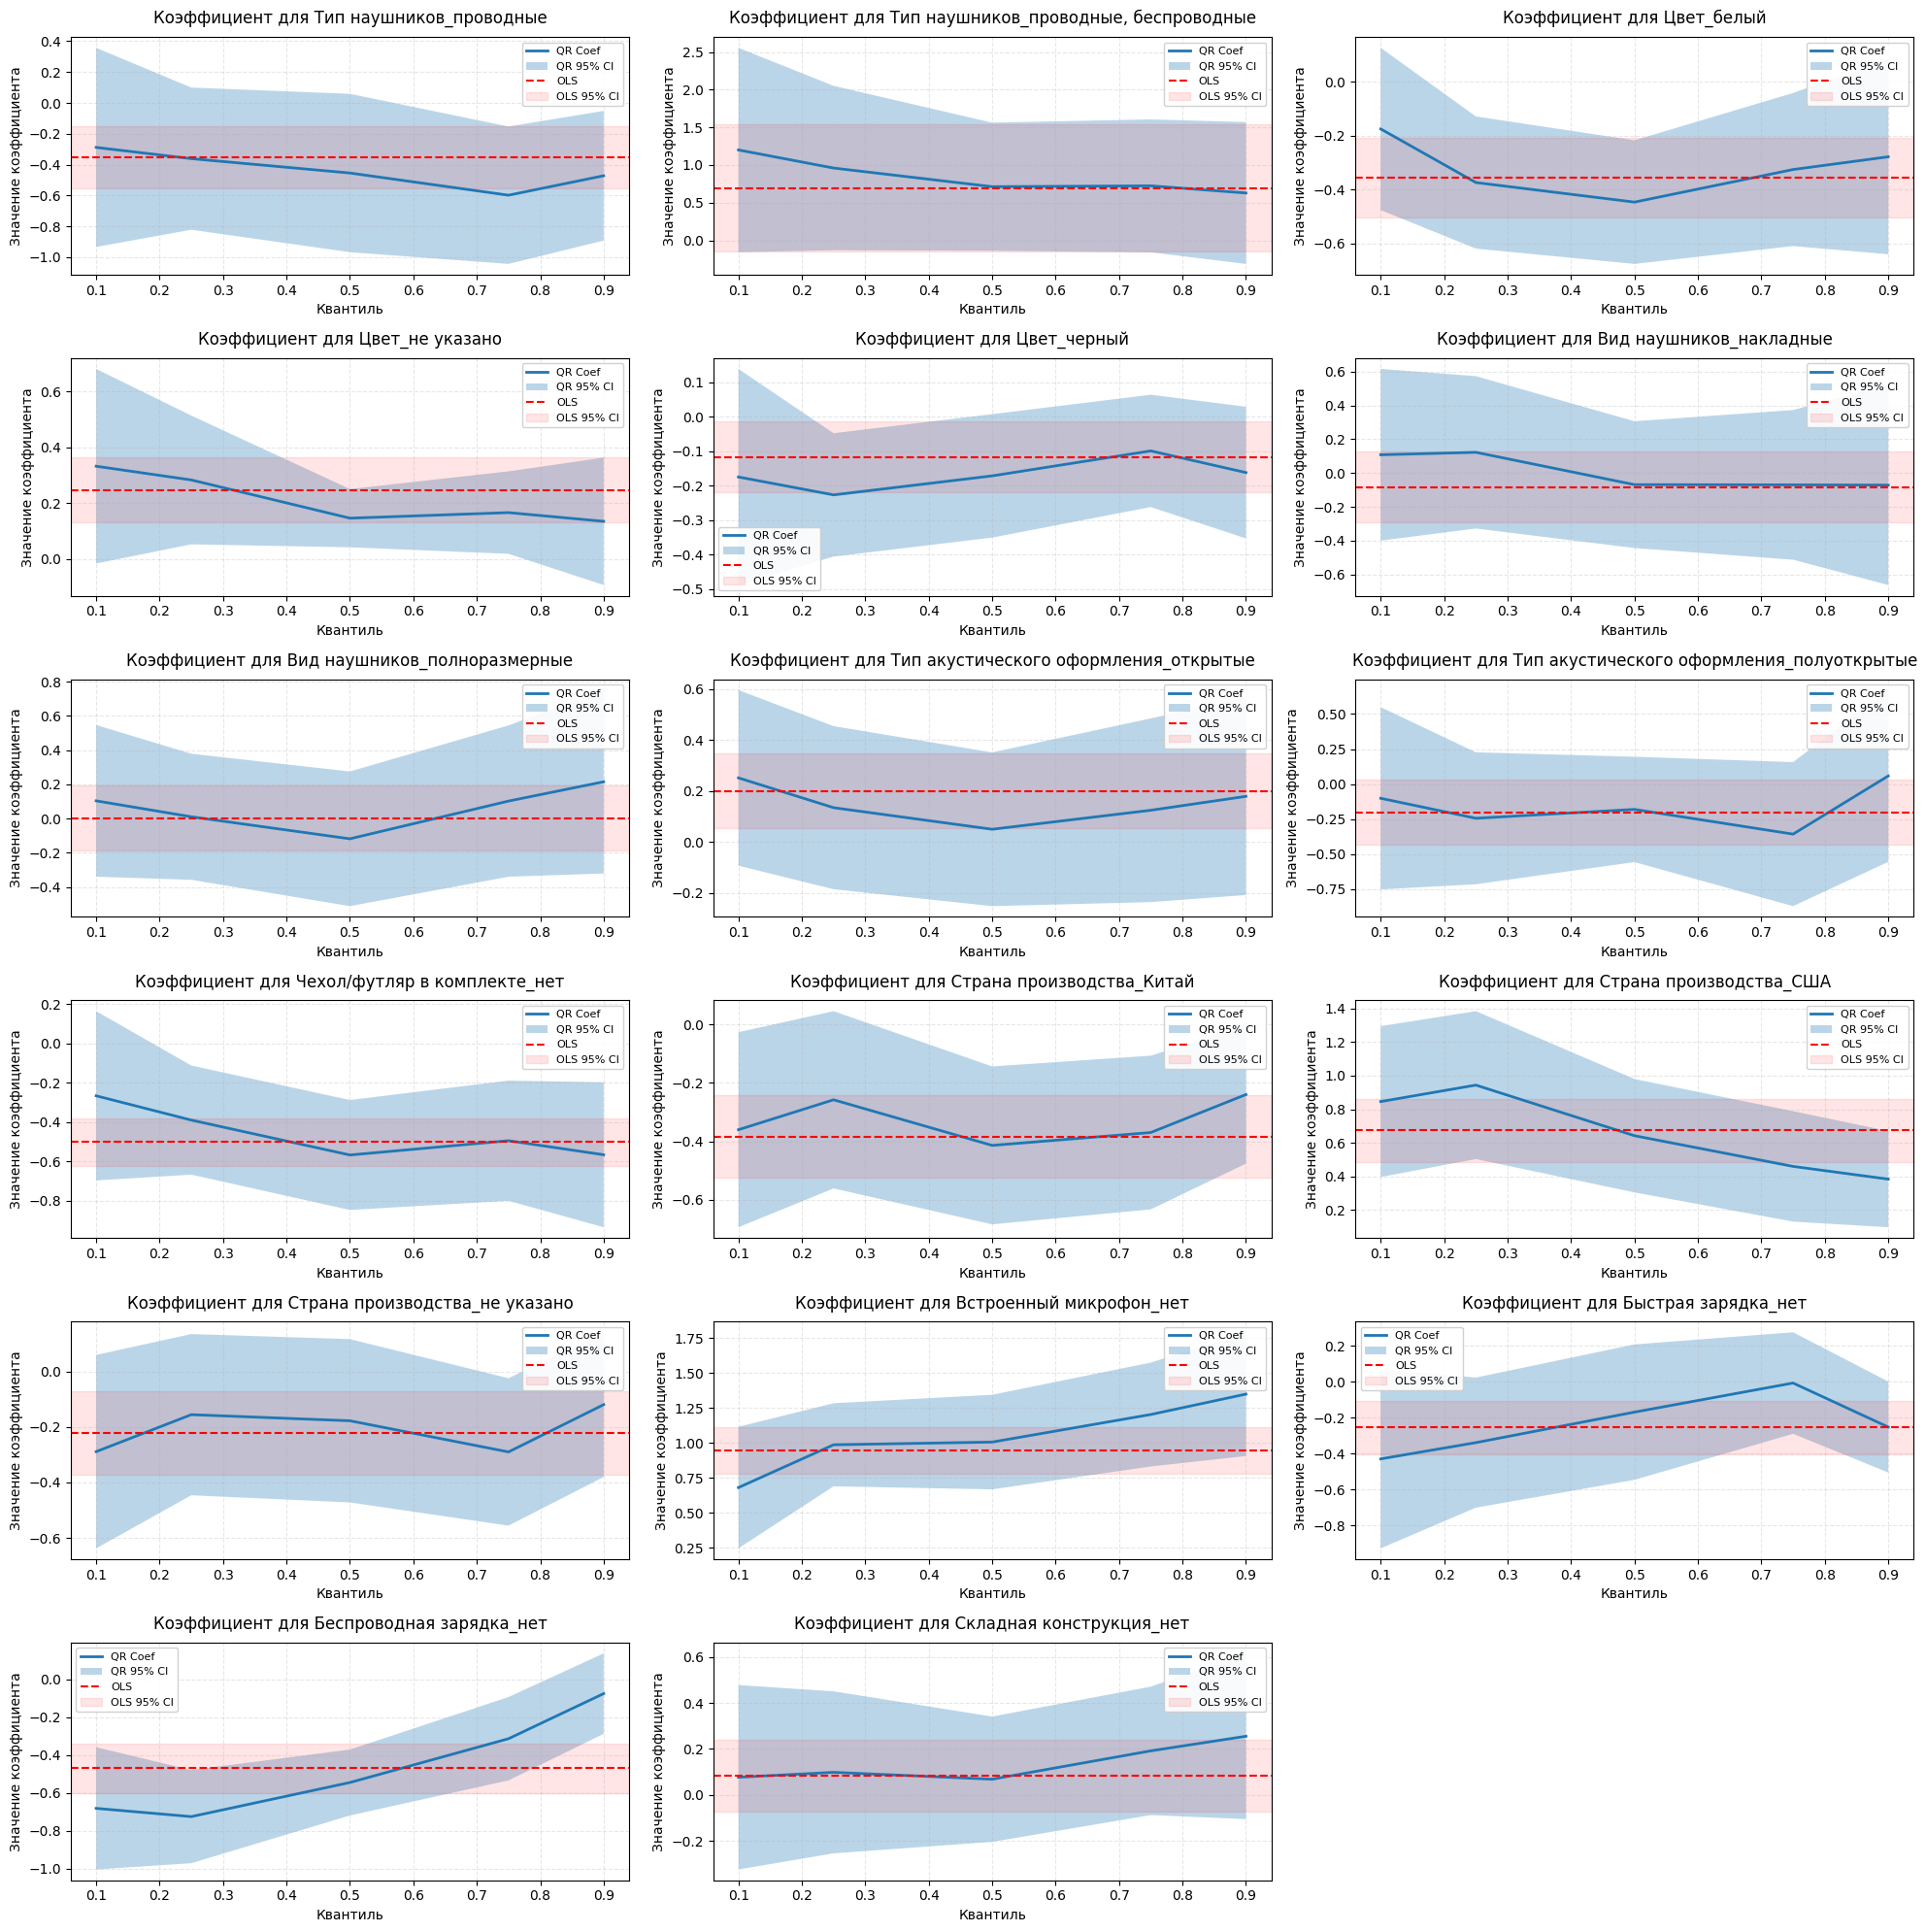

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

main_predictors = ['Минимальная воспроизводимая частота, Гц',
                   'Максимальная воспроизводимая частота, кГц',
                   'Вес, г',
                   'Срок службы, мес',
                   ]

binary_vars = [
    'Тип наушников_проводные', 'Тип наушников_проводные, беспроводные',
    'Цвет_белый', 'Цвет_не указано', 'Цвет_черный',
    'Вид наушников_накладные', 'Вид наушников_полноразмерные',
    'Тип акустического оформления_открытые', 'Тип акустического оформления_полуоткрытые',
    'Чехол/футляр в комплекте_нет', 'Страна производства_Китай',
    'Страна производства_США', 'Страна производства_не указано',
    'Встроенный микрофон_нет', 'Быстрая зарядка_нет',
    'Беспроводная зарядка_нет', 'Складная конструкция_нет'
]

all_features = main_predictors + binary_vars

bse_index = {name: idx for idx, name in enumerate(all_features)}


plot_data = pd.DataFrame()
for q in quantiles_mq:
    model = models_mq[quantiles_mq.index(q)]
    coefs = {'quantile': q}

    for feature in all_features:
        if feature in model.params:
            idx = bse_index[feature]
            coef = model.params[feature]
            se = model.bse[idx]
            coefs[f'{feature}_coef'] = coef
            coefs[f'{feature}_lower'] = coef - 1.96 * se
            coefs[f'{feature}_upper'] = coef + 1.96 * se

    plot_data = pd.concat([plot_data, pd.DataFrame([coefs])], ignore_index=True)


def plot_feature_coefficients(features, title_prefix, name_to_save, ncols=3, figsize=(18, 12)):
    n = len(features)
    nrows = -(-n // ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i, feature in enumerate(features):
        ax = axes[i]
        coef_col = f'{feature}_coef'
        lower_col = f'{feature}_lower'
        upper_col = f'{feature}_upper'

        if coef_col not in plot_data.columns:
            continue

        sns.lineplot(data=plot_data, x='quantile', y=coef_col, ax=ax,
                     label='QR Coef', linewidth=2)
        ax.fill_between(plot_data['quantile'], plot_data[lower_col], plot_data[upper_col],
                        alpha=0.3, label='QR 95% CI')

        ols_name = feature if feature != 'const' else 'Intercept'
        if ols_name in ols_model.params.index:
            ax.axhline(ols_model.params[ols_name], color='red', linestyle='--',
                       linewidth=1.5, label='OLS')
            ci = ols_model.conf_int().loc[ols_name]
            ax.axhspan(ci[0], ci[1], color='red', alpha=0.1, label='OLS 95% CI')

        ax.set_title(f'{title_prefix} {feature}', fontsize=12, pad=10)
        ax.set_xlabel('Квантиль', fontsize=10)
        ax.set_ylabel('Значение коэффициента', fontsize=10)
        ax.legend(fontsize=8, framealpha=0.9)
        ax.grid(True, linestyle='--', alpha=0.3)

    for j in range(n, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(name_to_save, dpi=300)
    plt.show()



# непрерывные переменные
plot_feature_coefficients(main_predictors, 'Коэффициент для', name_to_save = "quantile_interval_num.png")

# бинарные переменные
plot_feature_coefficients(binary_vars, 'Коэффициент для', name_to_save = "quantile_interval_cat.png", ncols=3, figsize=(20, 20))


# 5. Прайсинг

In [ ]:
inverse_boxcox_transform = lambda x: (x * best_lambda + 1) ** (1/best_lambda)

In [ ]:
most_valuable = df_cleaned[df_cleaned["Цена"] == df_cleaned["Цена"].max()]

most_valuable["Срок службы, мес"] = 12
most_valuable["Чехол/футляр в комплекте_нет"] = 1
most_valuable["Страна производства_Китай"] = 1

y_predict = most_valuable["Цена"]

/tmp/ipykernel_31/2360901987.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_valuable["Срок службы, мес"] = 12
/tmp/ipykernel_31/2360901987.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_valuable["Чехол/футляр в комплекте_нет"] = 1
/tmp/ipykernel_31/2360901987.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [ ]:
X = most_valuable.drop("Цена", axis=1).copy()


X = sm.add_constant(X, has_constant='add')  # важно has_constant='add'



X = X[model_fgls.model.exog_names]

predictions = model_fgls.predict(X)

In [ ]:
# Изменение предсказания для самого дорого товара - показывает проблемность ценообразования этой модели

print("Было", inverse_boxcox_transform(y_predict.values[0]))
print("Стало", inverse_boxcox_transform(predictions.values[0]))

Было 6699999.999999994
Стало 24341.256059859654


## 5.2. Несущественные изменения нескольких признаков

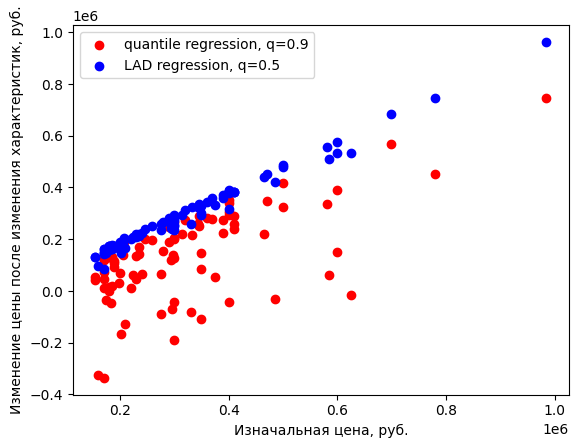

In [ ]:
# сделаем квантильную регрессию q=0.9 для самых дорогих товаров

X = df_cleaned.drop("Цена", axis=1)
X = sm.add_constant(X)
y = df_cleaned["Цена"]

most_precious = y.sort_values()[-90:-1].index
X_price = X.loc[most_precious]
y_price = y.loc[most_precious]

X_price["Срок службы, мес"] = 12
X_price["Чехол/футляр в комплекте_нет"] = 1
X_price["Страна производства_Китай"] = 1
model = sm.QuantReg(y, X)
result = model.fit(q=0.9)
predictions_quantile = result.predict(X_price)

model = sm.QuantReg(y, X)
result = model.fit(q=0.5)
predictions_median = result.predict(X_price)

initial_price = inverse_boxcox_transform(y_price)
predicted_price = inverse_boxcox_transform(predictions_quantile)
predicted_median_price = inverse_boxcox_transform(predictions_median)
diff = initial_price - predicted_price
diff2 = initial_price - predicted_median_price

plt.scatter(initial_price, diff, c = "red", label = "quantile regression, q=0.9")
plt.scatter(initial_price, diff2, c = "blue", label = "LAD regression, q=0.5")
plt.xlabel("Изначальная цена, руб.")
plt.ylabel("Изменение цены после изменения характеристик, руб.")
plt.legend()
plt.savefig("Difference_high_quantile.png", dpi=300);

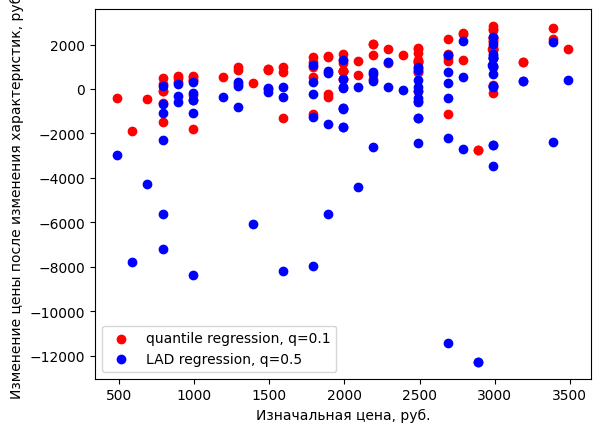

In [ ]:
# сделаем квантильную регрессию q=0.9 для самых дорогих товаров

X = df_cleaned.drop("Цена", axis=1)
X = sm.add_constant(X)
y = df_cleaned["Цена"]

least_precious = y.sort_values()[:100].index
X_price = X.loc[least_precious]
y_price = y.loc[least_precious]

X_price["Срок службы, мес"] = 12
X_price["Чехол/футляр в комплекте_нет"] = 1
X_price["Страна производства_Китай"] = 1
model = sm.QuantReg(y, X)
result = model.fit(q=0.1)
predictions_quantile = result.predict(X_price)

model = sm.QuantReg(y, X)
result = model.fit(q=0.5)
predictions_median = result.predict(X_price)

initial_price = inverse_boxcox_transform(y_price)
predicted_price = inverse_boxcox_transform(predictions_quantile)
predicted_median_price = inverse_boxcox_transform(predictions_median)
diff = initial_price - predicted_price
diff2 = initial_price - predicted_median_price

plt.scatter(initial_price, diff, c = "red", label = "quantile regression, q=0.1")
plt.scatter(initial_price, diff2, c = "blue", label = "LAD regression, q=0.5")
plt.xlabel("Изначальная цена, руб.")
plt.ylabel("Изменение цены после изменения характеристик, руб.")
plt.legend()
plt.savefig("Difference_low_quantile.png", dpi=300);

count    863.000000
mean       7.909295
std        0.923419
min        5.380735
25%        7.263291
50%        7.975475
75%        8.421153
max       11.144055
Name: Цена, dtype: float64


<Axes: >

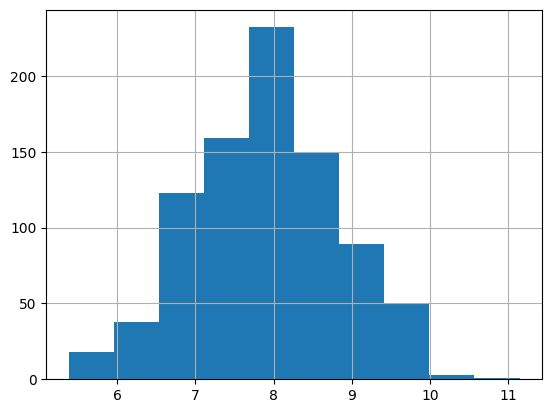

In [ ]:
# теперь отберем средние значения для прайсинга
print(y.describe())
y.hist()

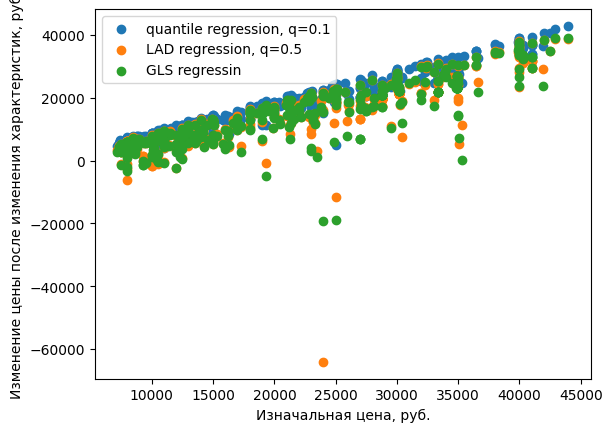

In [ ]:
mean_objects = y[(y > y.quantile(0.25)) & (y < y.quantile(0.75))].index
X_price = X.loc[mean_objects]
y_price = y.loc[mean_objects]

X_price["Срок службы, мес"] = 12
X_price["Чехол/футляр в комплекте_нет"] = 1
X_price["Страна производства_Китай"] = 1
model = sm.QuantReg(y, X)
result = model.fit(q=0.9)
predictions_high_quantile = result.predict(X_price)

model = sm.QuantReg(y, X)
result = model.fit(q=0.1)
predictions_low_quantile = result.predict(X_price)

model = sm.QuantReg(y, X)
result = model.fit(q=0.5)
predictions_median = result.predict(X_price)

model = sm.GLS(y, X)
result = model.fit()
predictions_gls = result.predict(X_price)

initial_price = inverse_boxcox_transform(y_price)
predicted_price_high = inverse_boxcox_transform(predictions_high_quantile)
predicted_price_low = inverse_boxcox_transform(predictions_low_quantile)
predicted_price_gls = inverse_boxcox_transform(predictions_gls)
predicted_median_price = inverse_boxcox_transform(predictions_median)
diff_high = initial_price - predicted_price_high
diff_low = initial_price - predicted_price_low
diff_median =  initial_price - predicted_median_price
diff_gls = initial_price - predicted_price_gls

#plt.scatter(initial_price, diff_high, c = "red", label = "quantile regression, q=0.9")
plt.scatter(initial_price, diff_low, label = "quantile regression, q=0.1")
plt.scatter(initial_price, diff_median, label = "LAD regression, q=0.5")
plt.scatter(initial_price, diff_gls, label = "GLS regressin")
plt.xlabel("Изначальная цена, руб.")
plt.ylabel("Изменение цены после изменения характеристик, руб.")
plt.legend()
plt.savefig("Difference_mean.png", dpi=300);

## 5.3. Проверка робастности при изменении одного признака

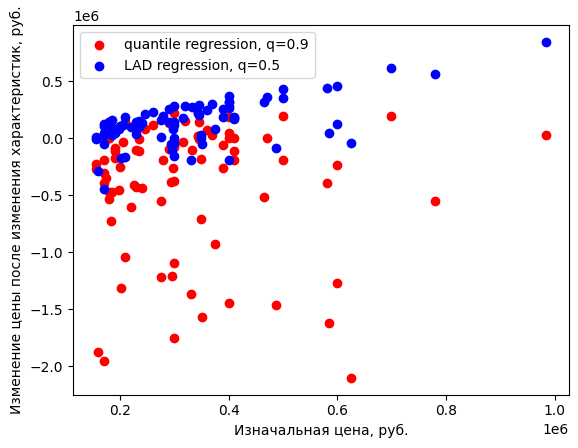

In [ ]:
# сделаем квантильную регрессию q=0.9 для самых дорогих товаров

X = df_cleaned.drop("Цена", axis=1)
X = sm.add_constant(X)
y = df_cleaned["Цена"]

most_precious = y.sort_values()[-90:-1].index
X_price = X.loc[most_precious]
y_price = y.loc[most_precious]

X_price["Чехол/футляр в комплекте_нет"] = 0
model = sm.QuantReg(y, X)
result = model.fit(q=0.9)
predictions_quantile = result.predict(X_price)

model = sm.QuantReg(y, X)
result = model.fit(q=0.5)
predictions_median = result.predict(X_price)

initial_price = inverse_boxcox_transform(y_price)
predicted_price = inverse_boxcox_transform(predictions_quantile)
predicted_median_price = inverse_boxcox_transform(predictions_median)
diff = initial_price - predicted_price
diff2 = initial_price - predicted_median_price

plt.scatter(initial_price, diff, c = "red", label = "quantile regression, q=0.9")
plt.scatter(initial_price, diff2, c = "blue", label = "LAD regression, q=0.5")
plt.xlabel("Изначальная цена, руб.")
plt.ylabel("Изменение цены после изменения характеристик, руб.")
plt.legend()
plt.savefig("Difference_high_quantile2.png", dpi=300);

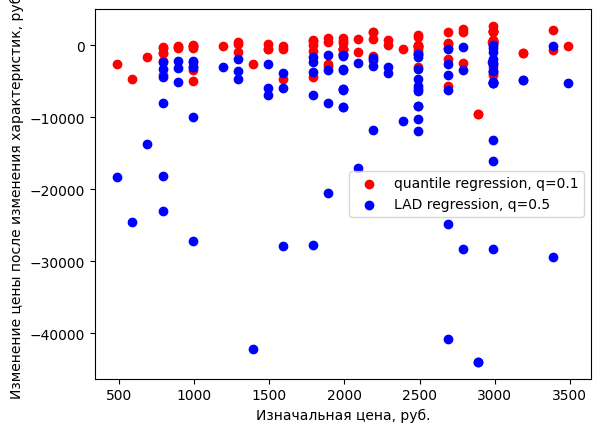

In [ ]:
# сделаем квантильную регрессию q=0.9 для самых дорогих товаров

X = df_cleaned.drop("Цена", axis=1)
X = sm.add_constant(X)
y = df_cleaned["Цена"]

least_precious = y.sort_values()[:100].index
X_price = X.loc[least_precious]
y_price = y.loc[least_precious]

X_price["Чехол/футляр в комплекте_нет"] = 0
model = sm.QuantReg(y, X)
result = model.fit(q=0.1)
predictions_quantile = result.predict(X_price)

model = sm.QuantReg(y, X)
result = model.fit(q=0.5)
predictions_median = result.predict(X_price)

initial_price = inverse_boxcox_transform(y_price)
predicted_price = inverse_boxcox_transform(predictions_quantile)
predicted_median_price = inverse_boxcox_transform(predictions_median)
diff = initial_price - predicted_price
diff2 = initial_price - predicted_median_price

plt.scatter(initial_price, diff, c = "red", label = "quantile regression, q=0.1")
plt.scatter(initial_price, diff2, c = "blue", label = "LAD regression, q=0.5")
plt.xlabel("Изначальная цена, руб.")
plt.ylabel("Изменение цены после изменения характеристик, руб.")
plt.legend()
plt.savefig("Difference_low_quantile2.png", dpi=300);

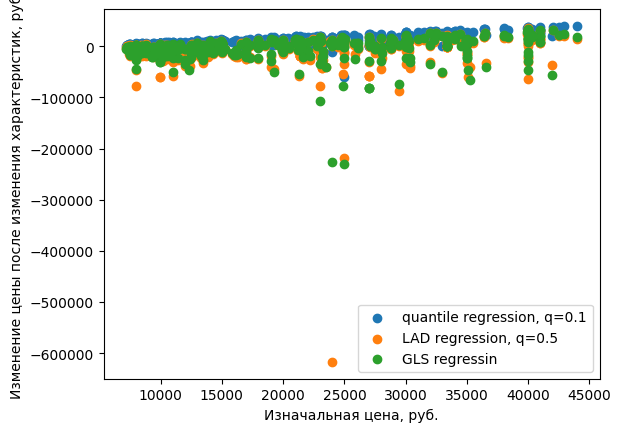

In [ ]:
mean_objects = y[(y > y.quantile(0.25)) & (y < y.quantile(0.75))].index
X_price = X.loc[mean_objects]
y_price = y.loc[mean_objects]


X_price["Чехол/футляр в комплекте_нет"] = 0
model = sm.QuantReg(y, X)
result = model.fit(q=0.9)
predictions_high_quantile = result.predict(X_price)

model = sm.QuantReg(y, X)
result = model.fit(q=0.1)
predictions_low_quantile = result.predict(X_price)

model = sm.QuantReg(y, X)
result = model.fit(q=0.5)
predictions_median = result.predict(X_price)

model = sm.GLS(y, X)
result = model.fit()
predictions_gls = result.predict(X_price)

initial_price = inverse_boxcox_transform(y_price)
predicted_price_high = inverse_boxcox_transform(predictions_high_quantile)
predicted_price_low = inverse_boxcox_transform(predictions_low_quantile)
predicted_price_gls = inverse_boxcox_transform(predictions_gls)
predicted_median_price = inverse_boxcox_transform(predictions_median)
diff_high = initial_price - predicted_price_high
diff_low = initial_price - predicted_price_low
diff_median =  initial_price - predicted_median_price
diff_gls = initial_price - predicted_price_gls

#plt.scatter(initial_price, diff_high, c = "red", label = "quantile regression, q=0.9")
plt.scatter(initial_price, diff_low, label = "quantile regression, q=0.1")
plt.scatter(initial_price, diff_median, label = "LAD regression, q=0.5")
plt.scatter(initial_price, diff_gls, label = "GLS regressin")
plt.xlabel("Изначальная цена, руб.")
plt.ylabel("Изменение цены после изменения характеристик, руб.")
plt.legend()
plt.savefig("Difference_mean2.png", dpi=300);

## 5.4. Сравнение с более сильной моделью

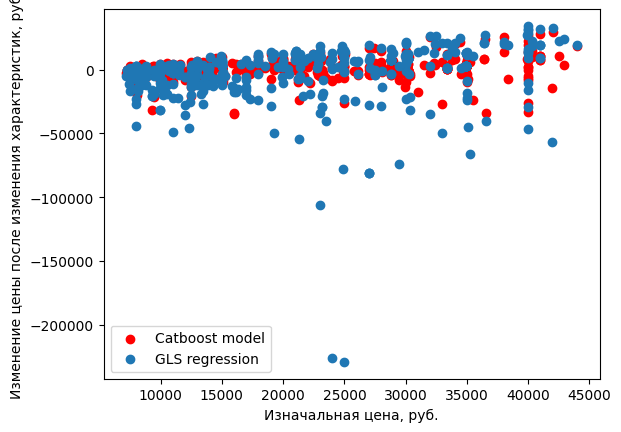

In [ ]:
from catboost import CatBoostRegressor

mean_objects = y[(y > y.quantile(0.25)) & (y < y.quantile(0.75))].index
X_price = X.loc[mean_objects]
y_price = y.loc[mean_objects]


X_price["Чехол/футляр в комплекте_нет"] = 0

model = sm.GLS(y, X)
result = model.fit()
predictions_gls = result.predict(X_price)

model = CatBoostRegressor(silent = True)
model.fit(X,y)
predictions_catboost = model.predict(X_price)

initial_price = inverse_boxcox_transform(y_price)
predicted_price_gls = inverse_boxcox_transform(predictions_gls)
predicted_price_cat = inverse_boxcox_transform(predictions_catboost)
diff_gls = initial_price - predicted_price_gls
diff_cat = initial_price - predicted_price_cat

plt.scatter(initial_price, diff_cat, c = "red", label = "Catboost model")
plt.scatter(initial_price, diff_gls, label = "GLS regression")
plt.xlabel("Изначальная цена, руб.")
plt.ylabel("Изменение цены после изменения характеристик, руб.")
plt.legend()
plt.savefig("Difference_mean3.png", dpi=300);